In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import networkx as nx
import pyvis.network as net
from networkx import Graph

OPENSLIDE_PATH = r"D:\DataManage\openslide-win64-20231011\bin"
import os

if hasattr(os, "add_dll_directory"):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide
from openslide.deepzoom import DeepZoomGenerator

tqdm.pandas()

In [144]:
def get_tum_tiles(row, tum_tresh, inf_folder):
    """Get the tiles with a tumour prediction above a threshold"""
    path = inf_folder / row.sample_ID / "tiles.csv"
    assert path.exists(), f"File {path} does not exist"
    tiles_pred = pd.read_csv(path)
    tum_tiles = tiles_pred[tiles_pred.tum_pred > tum_tresh].copy()
    # tum_tiles.drop(columns="tum_pred", inplace=True)
    tum_tiles.rename(
        lambda x: x + "_pred" if x not in ["x", "y", "z", "tum_pred"] else x, axis=1, inplace=True
    )
    return tum_tiles


def display_tiles_top_bottom(pos_img, neg_img, sign):
    fig, axes = plt.subplots(3, 2 * 3, figsize=(9, 6))

    for i in range(3):
        for j in range(3):
            axes[i, j].imshow(pos_img[i * 3 + j])
            axes[i, j].axis("off")

    for i in range(3):
        for j in range(3):
            axes[i, j + 3].imshow(neg_img[i * 3 + j])
            axes[i, j + 3].axis("off")

    axes[0, 0].set_title("Top 9 tiles")
    axes[0, 3].set_title("Bottom 9 tiles")

    plt.suptitle(f"Top and bottom 9 tiles for {sign}")
    plt.tight_layout()
    plt.show()


def display_tiles_top(pos_img, sign):
    fig, axes = plt.subplots(3, 7, figsize=(9, 6))

    axes = axes.flatten()
    for i in range(21):
        axes[i].imshow(pos_img[i])
        axes[i].axis("off")

    plt.suptitle(f"Top 9 tiles for {sign}")
    plt.tight_layout()
    plt.show()

In [145]:
df_path_mdn = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_vst.csv")
inf_folder_mdn = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\inference_mdn")

In [146]:
df_mdn = pd.read_csv(df_path_mdn)
sig_names_mdn = df_mdn.columns[9:].values
# Rename the columns
for k in range(0, len(sig_names_mdn)):
    if sig_names_mdn[k][-1] == ".":
        sig_names_mdn[k] = sig_names_mdn[k][:-1]
        df_mdn.rename(columns={sig_names_mdn[k] + ".": sig_names_mdn[k]}, inplace=True)

In [147]:
row = df_mdn.iloc[np.random.randint(len(df_mdn))]

# slide = openslide.OpenSlide(str(row.path_svs))
# dz = DeepZoomGenerator(slide, tile_size=224, overlap=0)

In [148]:
# tiles_pred = get_tum_tiles(row, 0.0, inf_folder_mdn)

In [149]:
# print("Number of tiles: ", len(tiles_pred))

# top_preds_sign = sig_names_mdn
# top_preds_sign = ["PDAC_Bailey16_ADEX", "Exocrine", "PDAC_PDAssigner_Exocrine"]

# for sign in top_preds_sign:
#     cols_of_interest = tiles_pred[["z", "x", "y", sign + "_pred"]]
#     cols_of_interest = cols_of_interest.sort_values(by=sign + "_pred", ascending=False)

#     # Sample the top and bottom 9 tiles that are not white
#     pos_img = []
#     pos_idx = 0
#     while len(pos_img) < 9:
#         try:
#             row = cols_of_interest.iloc[pos_idx]
#         except IndexError:
#             raise IndexError(f"Could not find 9 tiles for {sign}. {pos_idx=}")
#         img = dz.get_tile(int(row.z), (int(row.x), int(row.y)))
#         if np.mean(img) < 230:
#             pos_img.append(img)
#         pos_idx += 1

#     neg_img = []
#     neg_idx = 0
#     while len(neg_img) < 9:
#         try:
#             row = cols_of_interest.iloc[-(neg_idx + 1)]
#         except IndexError:
#             raise IndexError(f"Could not find 9 tiles for {sign}. {neg_idx=}")
#         img = dz.get_tile(int(row.z), (int(row.x), int(row.y)))
#         if np.mean(img) < 230:
#             neg_img.append(img)
#         neg_idx += 1

#     # top_tiles = cols_of_interest.head(9)
#     # bottom_tiles = cols_of_interest.tail(9)

#     # pos_img = [dz.get_tile(int(row.z), (int(row.x), int(row.y))) for _, row in top_tiles.iterrows()]
#     # neg_img = [dz.get_tile(int(row.z), (int(row.x), int(row.y))) for _, row in bottom_tiles.iterrows()]
#     display_tiles_top_bottom(pos_img, neg_img, sign)

In [156]:
top_preds_sign = ["PDAC_Bailey16_ADEX", "Exocrine", "PDAC_PDAssigner_Exocrine", "Classic"]

In [157]:
def get_top_tiles(row, top_preds_sign, inf_folder, tum_tresh=0.0, n_top=21):
    """Get the tiles with a tumour prediction above a threshold"""
    path = inf_folder / row.sample_ID / "tiles.csv"
    assert path.exists(), f"File {path} does not exist"
    tiles_pred = pd.read_csv(path)
    tum_tiles = tiles_pred[tiles_pred.tum_pred > tum_tresh].copy()
    # tum_tiles.drop(columns="tum_pred", inplace=True)
    rename_func = lambda x: x + "_pred" if x not in ["x", "y", "z", "tum_pred"] else x
    tum_tiles.rename(rename_func, axis=1, inplace=True)

    top_tiles = []
    for sign in top_preds_sign:
        top_tiles_ = tum_tiles.sort_values(by=sign + "_pred", ascending=False).head(n_top)
        top_tiles.append(top_tiles_)
    top_tiles = pd.concat(top_tiles, axis=0)
    top_tiles = top_tiles.drop_duplicates(subset=["x", "y", "z"], keep="first")
    top_tiles["path_svs"] = row["path_svs"]
    return top_tiles

In [158]:
top_tiles_0 = get_top_tiles(df_mdn.iloc[0], top_preds_sign, inf_folder_mdn)
top_tiles_1 = get_top_tiles(df_mdn.iloc[1], top_preds_sign, inf_folder_mdn)

In [159]:
def update_max(df_0, df_1, sign_list, n_top=21):
    concat_df = pd.concat([df_0, df_1], axis=0)
    top_tiles = []
    for sign in sign_list:
        top_tiles_ = concat_df.sort_values(by=sign + "_pred", ascending=False).head(n_top)
        top_tiles.append(top_tiles_)
    top_tiles = pd.concat(top_tiles, axis=0)
    top_tiles = top_tiles.drop_duplicates(subset=["x", "y", "z", "path_svs"], keep="first")
    return top_tiles

In [160]:
top_tiles = get_top_tiles(df_mdn.iloc[0], top_preds_sign, inf_folder_mdn)
for idx, row in tqdm(df_mdn.iterrows(), total=len(df_mdn)):
    top_tiles_ = get_top_tiles(row, top_preds_sign, inf_folder_mdn)
    top_tiles = update_max(top_tiles, top_tiles_, top_preds_sign)

100%|██████████| 405/405 [00:08<00:00, 48.73it/s]


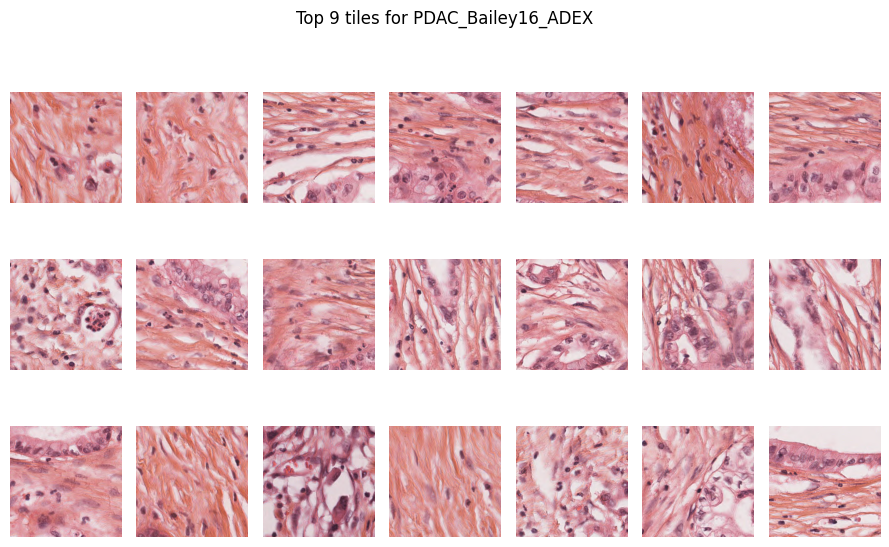

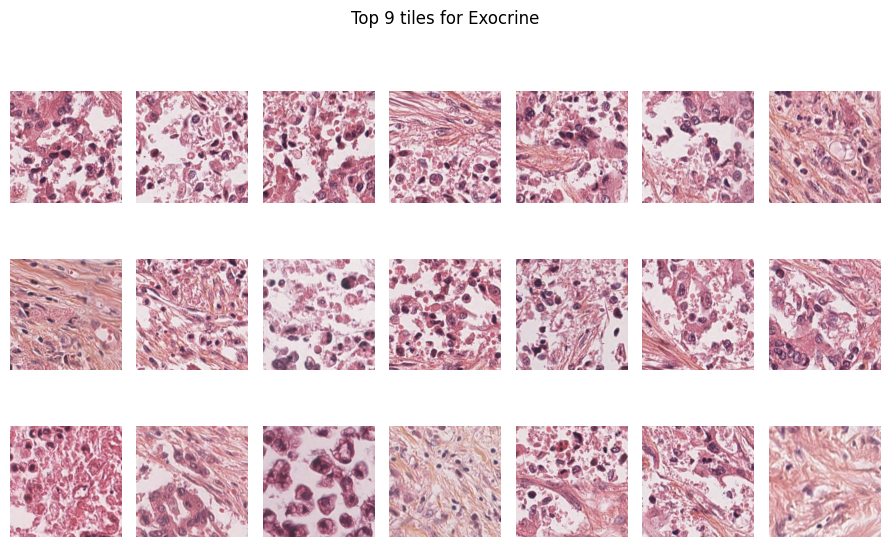

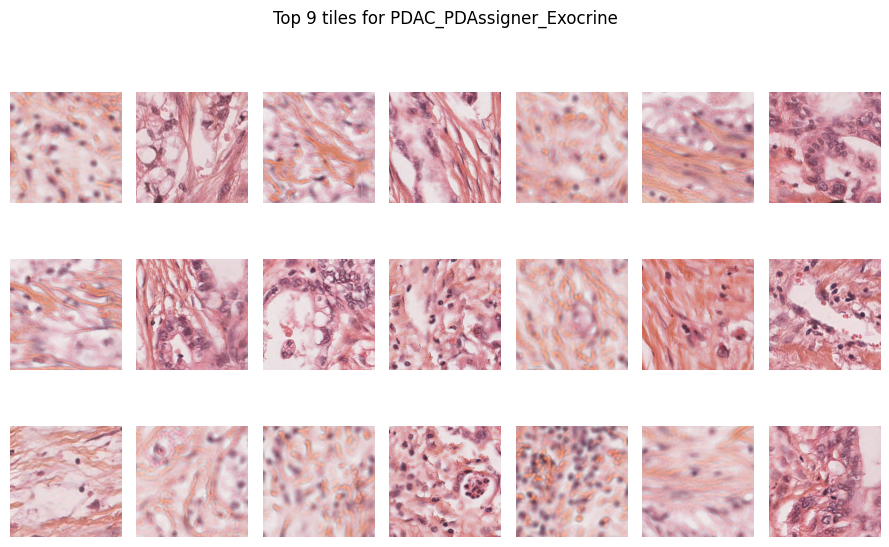

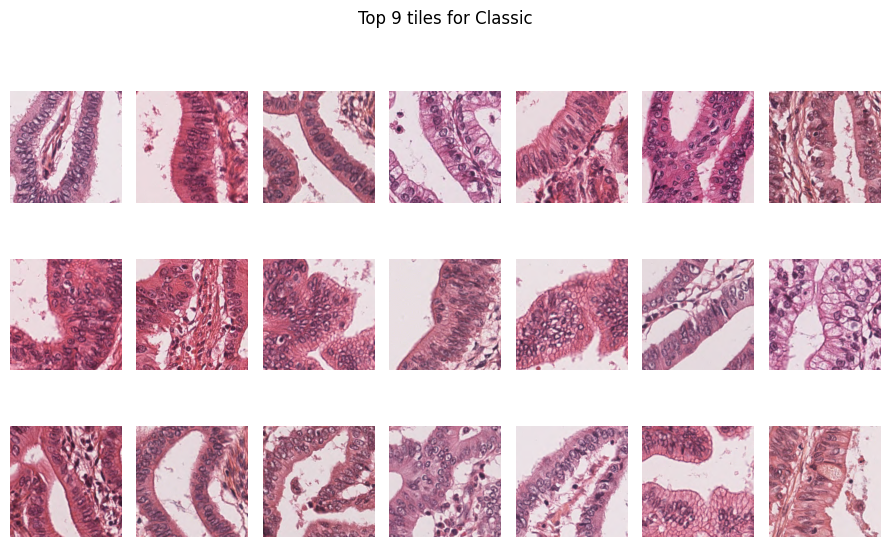

In [161]:
for sign in top_preds_sign:
    cols_of_interest = top_tiles[["z", "x", "y", sign + "_pred", "path_svs"]]
    cols_of_interest = cols_of_interest.sort_values(by=sign + "_pred", ascending=False)
    cols_of_interest = cols_of_interest.head(21)

    pos_img = []
    for idx, row in cols_of_interest.iterrows():
        slide = openslide.OpenSlide(str(row.path_svs))
        dz = DeepZoomGenerator(slide, tile_size=224, overlap=0)
        img = dz.get_tile(int(row.z), (int(row.x), int(row.y)))
        pos_img.append(img)

    display_tiles_top(pos_img, sign)